<a href="https://colab.research.google.com/github/dlsnfl03/Image-Analysis-U-net-/blob/main/U_Net_RMSProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import random

from random import shuffle
from PIL import Image

from pycocotools.coco import COCO

# 데이터 불러오기

In [ ]:
# 데이터셋 다운로드 및 압축 해제
!wget -nc http://images.cocodataset.org/zips/train2017.zip
!unzip -o -q /content/train2017.zip

!wget -nc http://images.cocodataset.org/zips/val2017.zip
!unzip -o -q /content/val2017.zip

!wget -nc http://images.cocodataset.org/zips/test2017.zip
!unzip -o -q /content/test2017.zip

# 주석 다운로드 및 압축 해제
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -o -q /content/annotations_trainval2017.zip

--2024-05-30 01:25:46--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.225.161, 3.5.11.201, 52.217.32.140, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.225.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  19.0MB/s    in 4m 36s  

2024-05-30 01:30:23 (66.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-05-30 01:35:02--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.68.140, 52.216.210.9, 52.217.143.9, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.68.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777

In [ ]:
# 경로 지정
dataDir = '/content'
dataType = 'train2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir, dataType)
imageDir = '{}/{}/'.format(dataDir, dataType)

# API 초기화
coco = COCO(annFile)

loading annotations into memory...
Done (t=25.42s)
creating index...
index created!


In [ ]:
# 카테고리 내용 출력
category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    print(cats)

number of categories:  80
[{'supercategory': 'person', 'id': 1, 'name': 'person'}]
[{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}]
[{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}]
[{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}]
[{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]
[{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}]
[{'supercategory': 'vehicle', 'id': 7, 'name': 'train'}]
[{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}]
[{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}]
[{'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}]
[{'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}]
[{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}]
[{'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}]
[{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}]
[{'supercategory': 'animal', 'id': 16, 'name': 'bird'}]
[{'supercategory': 'animal', 'id': 17, 'name': 'cat'}]
[{'supercategory': 'animal',

In [ ]:
img_ids = coco.getImgIds()

images = coco.loadImgs(img_ids)
print(len(images))

118287


In [ ]:
# 모든 카테고리에 대하여 annotation 추가
def display_images_with_annotations(images, coco, num_cols=4):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols

    # 카테고리별 색깔 지정
    category_colors = {}
    for ann in coco.dataset['annotations']:
        category_id = ann['category_id']
        if category_id not in category_colors:
            category_colors[category_id] = (random.random(), random.random(), random.random())  # Generate a random color for each category

    # subplot 생성
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()

    for i, img in enumerate(images):
        # 이미지 로드
        img_path = os.path.join(imageDir, img['file_name'])
        img_data = Image.open(img_path)
        axs[i].imshow(img_data)

        # annotation 로드
        ann_ids = coco.getAnnIds(imgIds=img['id'], iscrowd=False)
        anns = coco.loadAnns(ann_ids)

        # 각 annotation에 대하여 카테고리별 색깔 적용
        for ann in anns:
            bbox = ann['bbox']
            category_id = ann['category_id']
            category_name = coco.loadCats(category_id)[0]['name']
            color = category_colors.get(category_id, 'r')  # Use red color as default
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor=color, facecolor='none')
            axs[i].add_patch(rect)
            axs[i].text(bbox[0], bbox[1] - 2, category_name, fontsize=12, color='white', backgroundcolor=color)

        axs[i].axis('off')
        axs[i].set_title(f'Image ID: {img["id"]}')

    for j in range(num_images, num_rows * num_cols):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

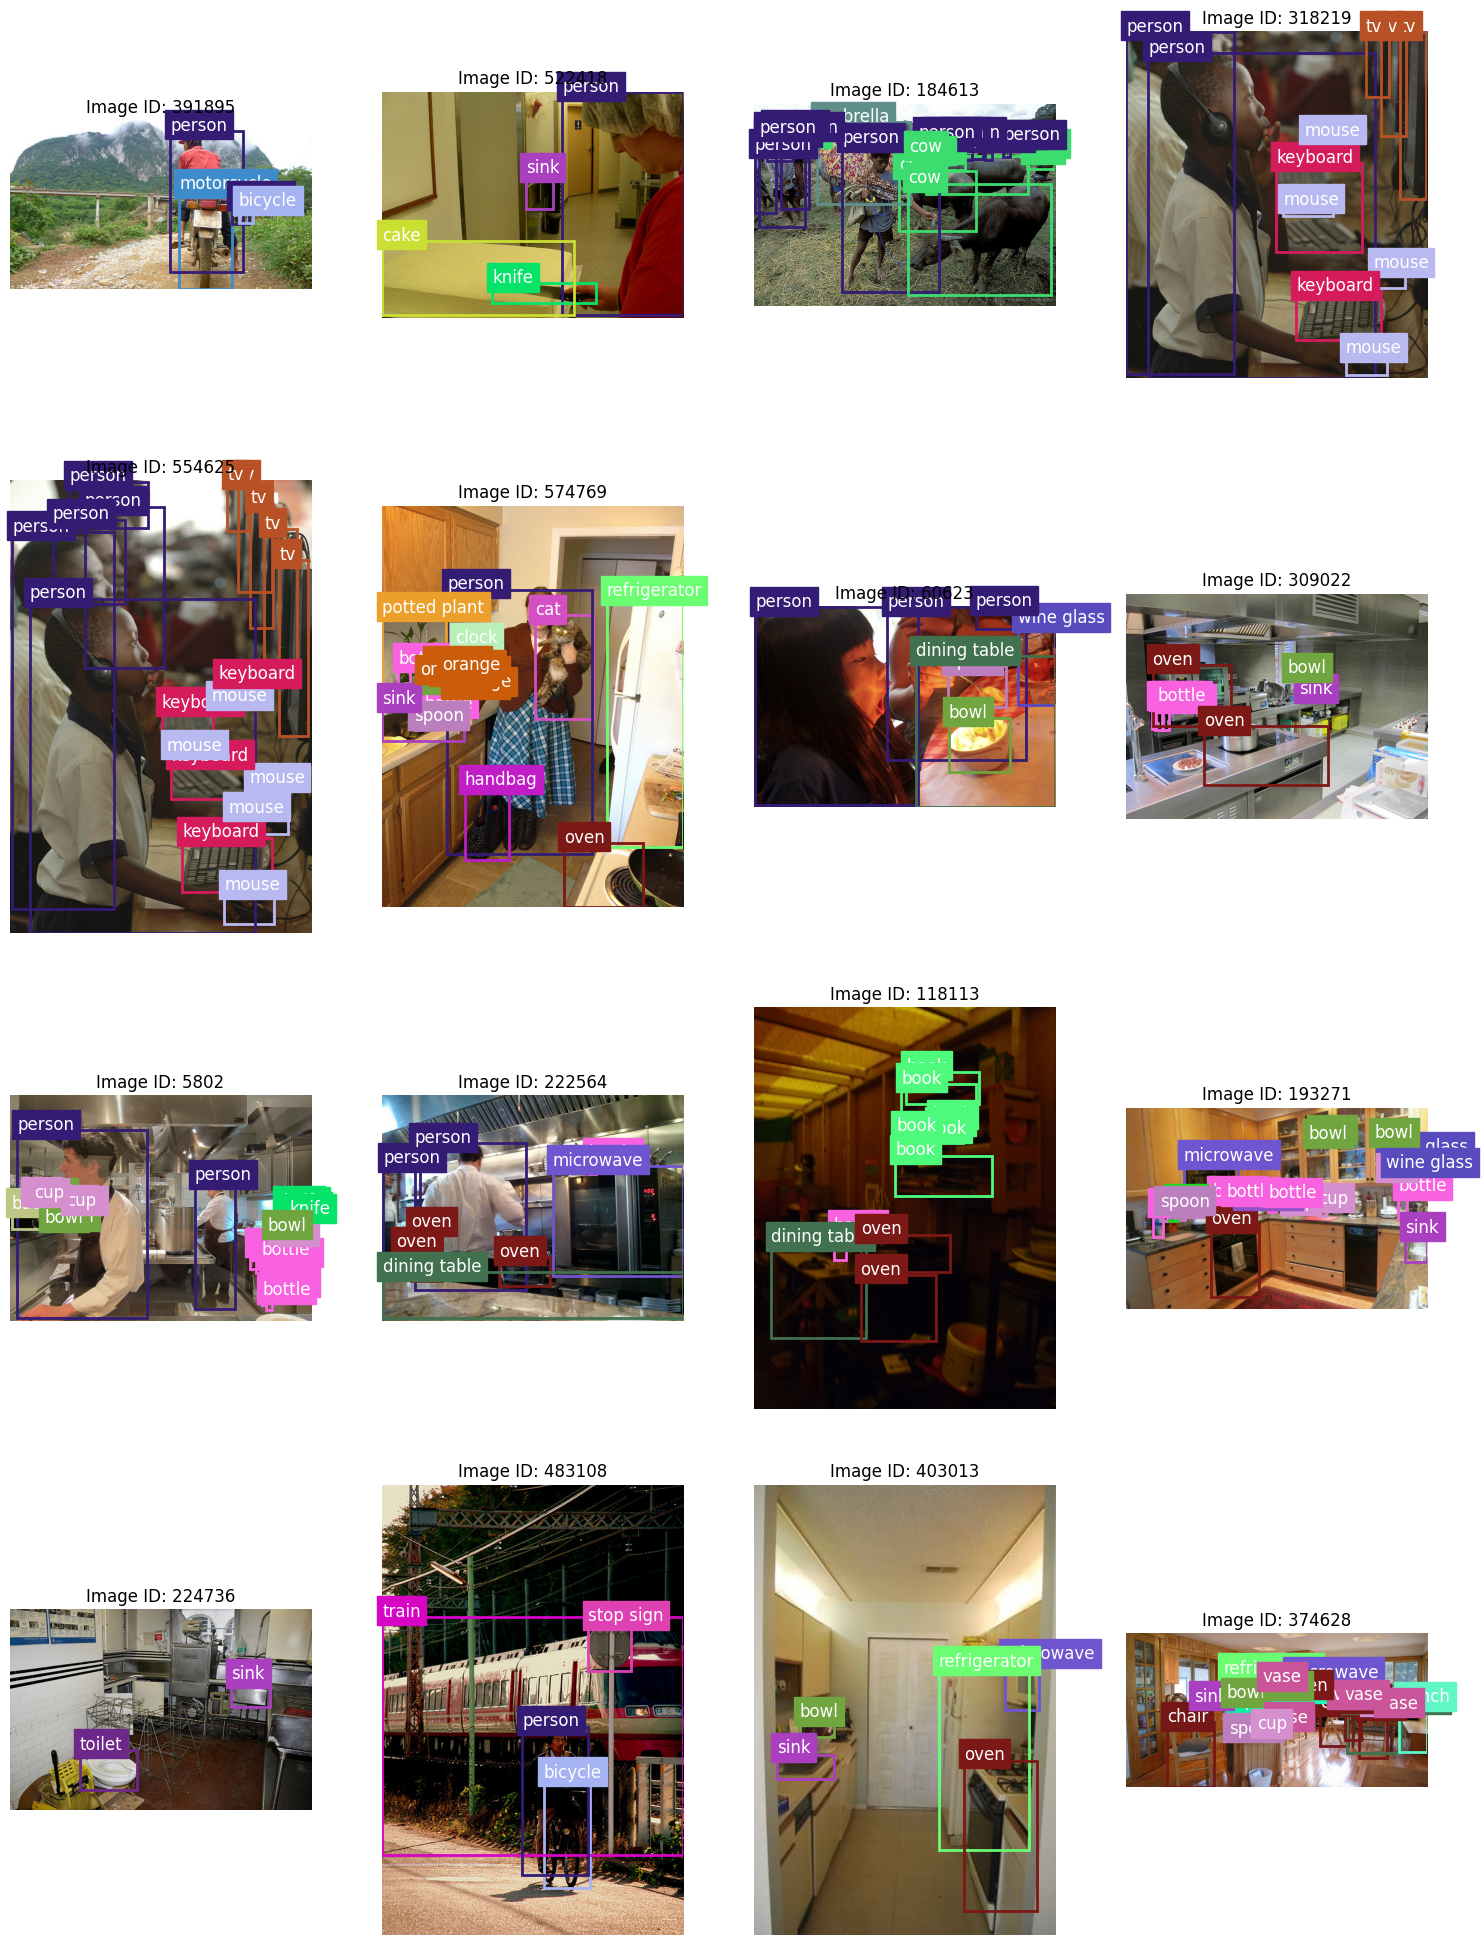

In [ ]:
display_images_with_annotations(images[:16], coco, num_cols=4)

In [ ]:
# 클래스 지정
cat_ids = coco.getCatIds(catNms=['person'])

# 이미지 불러오기
img_ids = coco.getImgIds(catIds=cat_ids)

# 이미지 정보 불러오기
images = coco.loadImgs(img_ids)
print(len(images))

64115


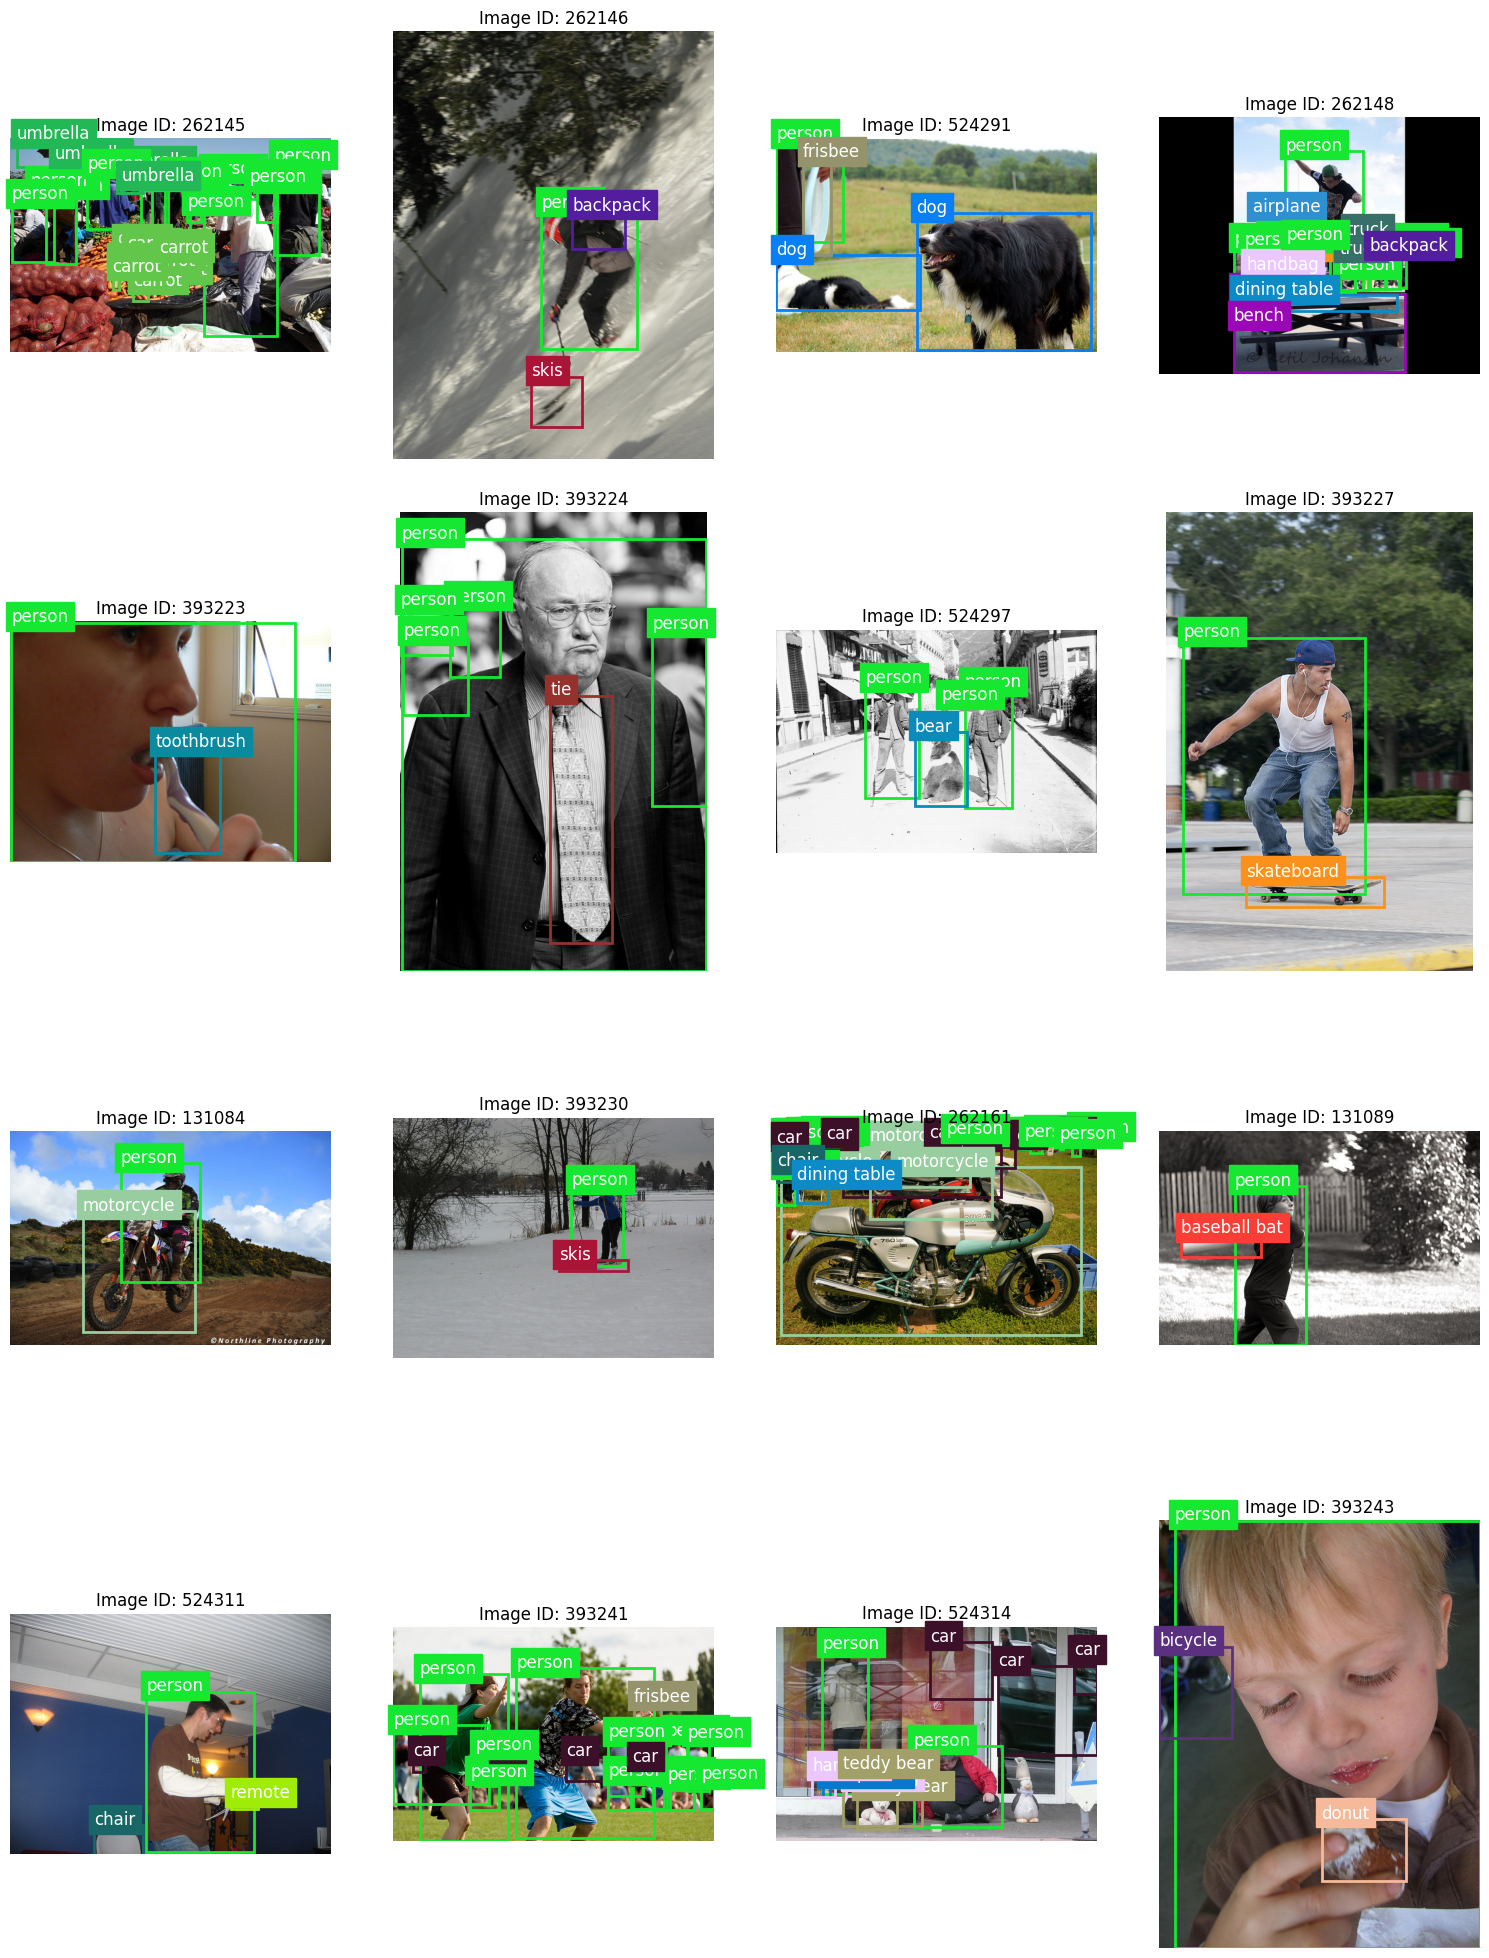

In [ ]:
display_images_with_annotations(images[:16], coco, num_cols=4)

In [ ]:
# 사람 이미지만 annotation 추가
def display_single_image_with_annotations(image, coco):
    img_path = os.path.join(imageDir, image['file_name'])
    img_data = Image.open(img_path)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_data)

    ann_ids = coco.getAnnIds(imgIds=image['id'], catIds=cat_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        bbox = ann['bbox']
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1] - 2, category_name, fontsize=12, color='white', backgroundcolor='red')

    ax.axis('off')
    ax.set_title(f'Image ID: {image["id"]}')
    plt.show()

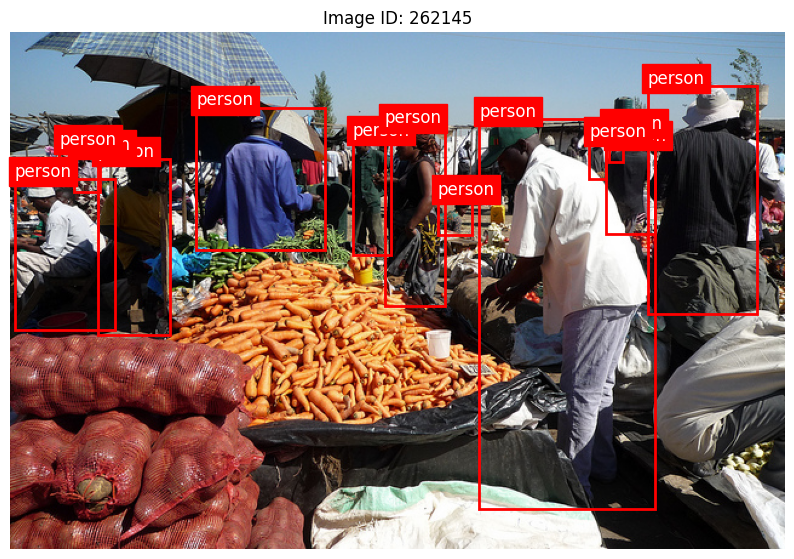

In [ ]:
display_single_image_with_annotations(images[0], coco)

# 전처리

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip uninstall -y tensorflow-io
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.2 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras

ANNOTATION_FILE_TRAIN = '/content/annotations/instances_train2017.json'
ANNOTATION_FILE_VAL = '/content/annotations/instances_val2017.json'

In [ ]:
# 클래스 지정
classes = ['person']

# train set의 API 초기화 및 카테고리 정보 로드
coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds(catNms=classes)
imgIds_train = coco_train.getImgIds(catIds=catIds_train)
imgDict_train = coco_train.loadImgs(imgIds_train)

# val set의 API 초기화 및 카테고리 정보 로드
coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds(catNms=classes)
imgIds_val = coco_val.getImgIds(catIds=catIds_val)
imgDict_val = coco_val.loadImgs(imgIds_val)

# 이미지 및 카테고리 수 출력
print(len(imgIds_train), len(catIds_train))
print(len(imgIds_val), len(catIds_val))

loading annotations into memory...
Done (t=55.87s)
creating index...
index created!
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
64115 1
2693 1


In [ ]:
# 이미지 ID 셔플
shuffle(imgIds_train)
shuffle(imgIds_val)

# 이미지 ID 서브셋 선택
imgIds_val = imgIds_val[0:600]
imgIds_train = imgIds_train[0:6000]

# 'person' 이미지 파일 이름 생성
train_images_person = ["train2017_{0:012d}.jpg".format(ids) for ids in imgIds_train]
val_images_person = ["val2017_{0:012d}.jpg".format(ids) for ids in imgIds_val]

# 'person' 이미지 파일 수 출력
print(len(train_images_person), len(val_images_person))

6000 600


In [ ]:
# train set의 'person' 이미지 파일 이름 목록 생성
train_images_person = ["train2017_{0:012d}.jpg".format(ids) for ids in imgIds_train]

# val set의 'person' 이미지 파일 이름 목록 생성
val_images_person = ["val2017_{0:012d}.jpg".format(ids) for ids in imgIds_val]

# 이미지 디렉토리 내 파일 수 확인
len(os.listdir("/content/val2017"))

5000

In [ ]:
# 생성할 훈련용 마스크를 저장할 디렉토리 생성
!mkdir mask_train2017

# count 변수 초기화
count = 0

# 훈련 이미지에 대한 마스크 생성
for ID in imgIds_train:

    # 마스크의 파일 경로 설정
    file_path = "/content/mask_train2017/train2017_{0:012d}.jpg".format(ID)

    # 훈련 세트에서 무작위 이미지 ID 가져오기
    sampleImgIds = coco_train.getImgIds(imgIds=[ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # 이미지에 대한 주석 ID 및 주석 가져오기
    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    # 개별 인스턴스 마스크를 결합하여 마스크 생성
    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
      mask = mask | coco_train.annToMask(anns[i])

    # 마스크를 이미지로 변환하고 저장
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)
    count = count + 1

In [ ]:
# 생성할 검증용 마스크를 저장할 디렉토리 생성
!mkdir mask_val2017

# count 변수 초기화
count = 0

# 검증 이미지에 대한 마스크 생성
for ID in imgIds_val:

    # 마스크의 파일 경로 설정
    file_path = "/content/mask_val2017/val2017_{0:012d}.jpg".format(ID)

    # 훈련 세트에서 무작위 이미지 ID 가져오기
    sampleImgIds = coco_val.getImgIds(imgIds=[ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # 이미지에 대한 주석 ID 및 주석 가져오기
    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    # 개별 인스턴스 마스크를 결합하여 마스크 생성
    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    # 마스크를 이미지로 변환하고 저장
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

    count = count + 1

In [ ]:
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size):
        """
        CustomDataGenerator class for generating batches of preprocessed images and masks.

        Args:
            images_path (str): Path to the directory containing the original images.
            masks_path (str): Path to the directory containing the corresponding masks.
            batch_size (int): Number of samples in each batch.

        Attributes:
            images_path (str): Path to the directory containing the original images.
            masks_path (str): Path to the directory containing the corresponding masks.
            batch_size (int): Number of samples in each batch.
            image_filenames (list): List of matching filenames between images and masks.
            mask_filenames (list): List of matching filenames between masks and images.
        """
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_filenames = self.get_matching_filenames()
        self.mask_filenames = self.get_matching_filenames()

    def get_matching_filenames(self):
        """
        Get the list of matching filenames between images and masks.

        Returns:
            list: List of matching filenames.
        """
        image_files = set([os.path.splitext(filename)[0] for filename in os.listdir(self.images_path)])
        mask_files = set([os.path.splitext(filename[len('train2017_'):])[0] for filename in os.listdir(self.masks_path)])
        matching_files = list(image_files.intersection(mask_files))
        return matching_files

    def __len__(self):
        """
        Get the number of batches in the generator.

        Returns:
            int: Number of batches.
        """
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
            """
            Get a batch of preprocessed images and masks.

            Args:
                idx (int): Batch index.

            Returns:
                tuple: Batch of preprocessed images and masks.
            """
            batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

            batch_images = []
            batch_masks = []

            for filename in batch_filenames:
                image_path = os.path.join(self.images_path, filename + '.jpg')
                mask_path = os.path.join(self.masks_path, 'train2017_' + filename + '.jpg')

                image = Image.open(image_path)
                mask = Image.open(mask_path)

                # 이미지와 마스크의 크기가 동일한지 확인
                if image.size != mask.size:
                    raise ValueError(f"Incompatible dimensions for image {image_path} and mask {mask_path}")

                #  이미지와 마스크를 크기 128x128로 조정
                image = image.resize((128, 128))
                mask = mask.resize((128, 128))

                # 이미지와 마스크를 배열로 변환
                preprocessed_image = np.array(image)
                preprocessed_mask = np.array(mask)

                # 이미지가 3채널이고 (128, 128, 3) 형태인지 확인
                if len(preprocessed_image.shape) == 3 and preprocessed_image.shape == (128, 128, 3):
                    # 정규화
                    preprocessed_image = preprocessed_image / 255.0
                    preprocessed_mask = preprocessed_mask / 255.0

                    # 전처리된 이미지와 마스크를 배치에 추가
                    batch_images.append(preprocessed_image)
                    batch_masks.append(preprocessed_mask)

            # 배치 이미지와 마스크를 넘파이 배열로 변환하고 반환
            return np.array(batch_images), np.array(batch_masks)

In [ ]:
images_path = '/content/train2017'
masks_path = '/content/mask_train2017'
batch_size = 8

# CustomDataGenerator의 인스턴스를 생성
train_generator = CustomDataGenerator(images_path, masks_path, batch_size)

In [ ]:
# 전처리 결과 확인
def validate_image_shapes(generator):
    """
    Print the shapes of preprocessed images generated by the provided generator.

    Args:
        generator (CustomDataGenerator): Instance of the CustomDataGenerator class.
    """
    for i in range(len(generator)):
        # Get a batch of preprocessed images from the generator
        batch_images, _ = generator[i]

        # Print the shapes of the preprocessed images
        for image in batch_images:
            print(f"Shape of preprocessed image: {image.shape}")

validate_image_shapes(train_generator)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preprocessed image: (128, 128, 3)
Shape of preproces

Image ID: 000000167171.jpg
Mask Shape: (128, 128)
Main Image Shape: (128, 128, 3)


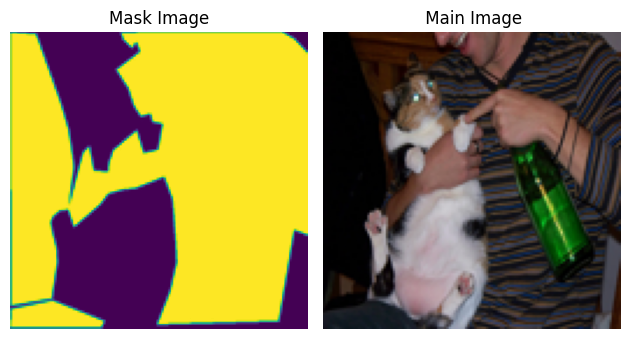

In [ ]:
batch_images, batch_masks = train_generator[0]

preprocessed_image = batch_images[0]
preprocessed_mask = batch_masks[0]

plt.subplot(1, 2, 1)
plt.imshow(preprocessed_mask)
plt.title('Mask Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title(' Main Image')
plt.axis('off')

print('Image ID:', train_generator.image_filenames[0]+'.jpg')
print('Mask Shape:', preprocessed_mask.shape)
print('Main Image Shape:', preprocessed_image.shape)

plt.tight_layout()
plt.show()

Image ID: 000000167171.jpg
Main Image Shape: (640, 480)


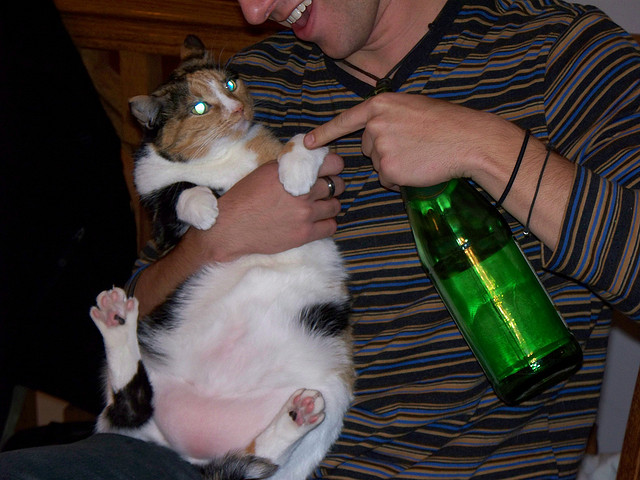

In [ ]:
import os
from PIL import Image

original_image = train_generator.image_filenames[0] + '.jpg'
original_image_path = '/content/train2017/{}'.format(original_image)
image = Image.open(original_image_path)

print('Image ID:', train_generator.image_filenames[0] + '.jpg')
print('Main Image Shape:', image.size)

Image.open(original_image_path)

# U-Net

In [ ]:
images_path = '/content/train2017'
masks_path = '/content/mask_train2017'
batch_size = 8

train_generator = CustomDataGenerator(images_path, masks_path, batch_size)
val_generator = CustomDataGenerator('/content/val2017', '/content/mask_val2017', batch_size)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
'''
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=10)
'''

"\nmodel = unet_model()\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\nmodel.fit(train_generator, validation_data=val_generator, epochs=10)\n"

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 컴파일
model = unet_model()
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

# 체크포인트 콜백 정의
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/데기인/checkpoint/best_model_RMSprop.h5',  # 모델 파일을 저장할 경로
    monitor='val_accuracy',    # 성능을 모니터링할 지표 (val_loss 또는 val_accuracy 등)
    save_best_only=True,       # 가장 좋은 모델만 저장
    mode='max',                # accuracy 모니터링 지표가 최대일 때 저장
    save_weights_only=True,    # 가중치만 저장하려면 True, 전체 모델을 저장하려면 False
    verbose=1                  # 로그 출력 설정
)

# 모델 학습
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    callbacks=[checkpoint_callback]
)

750/750 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8183 

750/750 [==============================] - 13524s 18s/step - loss: 0.4042 - accuracy: 0.8183


In [ ]:
model.save('/content/drive/MyDrive/데기인/checkpoint/RMSprop_final_model.h5')  # 전체 모델 저장

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/RMSprop_final_model.h5')